In [1]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#from torchvision.models.detection import (
#    fasterrcnn_resnet50_fpn, 
#    FasterRCNN_ResNet50_FPN_Weights
#    )
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
from torchvision.transforms import functional as F
import numpy as np

In [2]:
def load_model(checkpoint_path, num_classes=4):
#def load_model(checkpoint_path, num_classes=3):
    # 1. Инициализация модели с предобученными весами backbone
    #weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    #model = fasterrcnn_resnet50_fpn(weights=weights)
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn_v2(weights=weights)
    
    # 2. Замена box_predictor для своего числа классов
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # 3. Загрузка checkpoint
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    # 4. Извлекаем только веса модели (игнорируем optimizer и epoch)
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    # 5. Аккуратная загрузка весов
    model.load_state_dict(state_dict, strict=False)  # strict=False пропустит отсутствующие ключи
    
    # 6. Перевод в режим оценки
    model.eval()
    
    return model

In [3]:
model = load_model(
    checkpoint_path='/home/lastinm/PROJECTS/credit_cards_detection/train/Faster R-CNN/exp/summary/02-05-2025-15-46-48/best_model.pth',
    #checkpoint_path='/home/lastinm/PROJECTS/CV/experiments/FasterRCNN-Torchvision-FineTuning/exp/summary/02-04-2025-21-19-48/best_model.pth',
    #checkpoint_path='/home/lastinm/PROJECTS/CV/experiments/FasterRCNN-Torchvision-FineTuning-v2/exp/summary/04-04-2025-23-09-41/best_model.pth',
    #checkpoint_path='/home/lastinm/PROJECTS/CV/experiments/FasterRCNN-Torchvision-FineTuning-v2/exp/summary/09-04-2025-06-15-03/best_model.pth',
    num_classes=4  # Укажите реальное число ваших классов (3 класса + фон)
    #num_classes=3  # Укажите реальное число ваших классов (версия 2: 3 класса без фона)
    )

In [4]:
def detect_objects(model, image_path, confidence_threshold=0.7):
    """
    Детекция объектов на изображении с помощью загруженной модели
    Args:
        model: Загруженная модель Faster R-CNN
        image_path: Путь к изображению
        confidence_threshold: Порог уверенности для отображения (0.0-1.0)
    Returns:
        Словарь с результатами детекции
    """
    # 1. Загрузка и преобразование изображения
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV -> RGB
    image_tensor = F.to_tensor(image)  # Конвертация в тензор [0-1]

    # 2. Добавление batch dimension и перемещение на устройство (GPU/CPU)
    image_tensor = image_tensor.unsqueeze(0).to(next(model.parameters()).device)
    
    # 3. Запуск модели (без вычисления градиентов)
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # 4. Фильтрация результатов по порогу уверенности
    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()
    pred_classes = predictions[0]['labels'].cpu().numpy()
    
    keep = pred_scores >= confidence_threshold
    results = {
        'boxes': pred_boxes[keep],
        'scores': pred_scores[keep],
        'classes': pred_classes[keep]
    }
    
    return results

In [5]:
def visualize_results_matplotlib(image_path, results, class_names):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    
    colors = ['red', 'green', 'blue', 'yellow', 'purple']
    
    for box, score, cls in zip(results['boxes'], results['scores'], results['classes']):
        x1, y1, x2, y2 = map(int, box)
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor=colors[cls % len(colors)], facecolor='none'
        )
        ax.add_patch(rect)
        
        plt.text(
            x1, y1-10, f"{class_names[cls]}: {score:.2f}",
            color=colors[cls % len(colors)], fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8)
        )
    
    plt.axis('off')
    plt.show()

In [6]:
# СБЕР
#image_path = '/home/lastinm/PROJECTS/credit_cards_detection/dataset/_coco/test/1742460932042_resized_jpg.rf.cc580bf6003a8859a97b0c846b08415c.jpg'
# Авангард
image_path = '/home/lastinm/PROJECTS/credit_cards_detection/dataset/ocr val/1742460932124_resized_jpg.rf.ae82439353cb014cd13031eaed480be1.jpg'

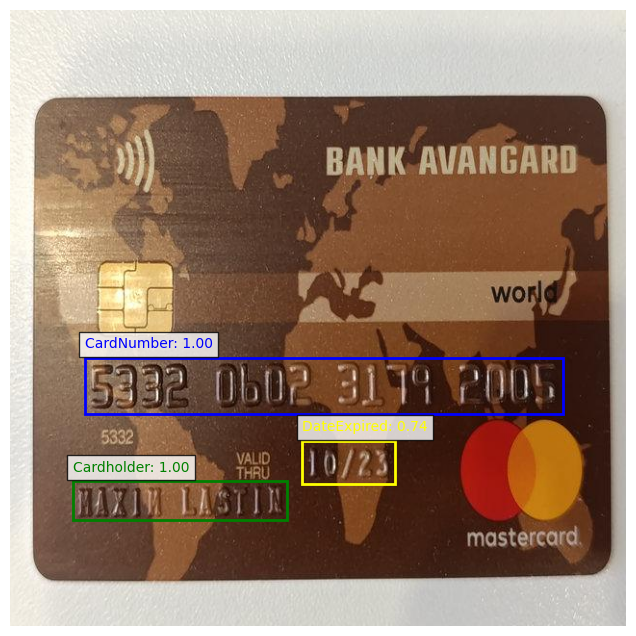

Найдено объектов: 3
Объект 1: Cardholder (уверенность: 1.00)
Координаты: x1=65.4, y1=489.9, x2=287.9, y2=530.0
Объект 2: CardNumber (уверенность: 1.00)
Координаты: x1=77.8, y1=361.1, x2=574.6, y2=419.4
Объект 3: DateExpired (уверенность: 0.74)
Координаты: x1=303.4, y1=447.1, x2=399.4, y2=492.6


In [7]:
# 1. Детекция на изображении
results = detect_objects(
    model=model,
    image_path=image_path,
    confidence_threshold=0.5  # Можно регулировать
    )
    
# 2. Визуализация
class_names = ["Background", "Cardholder", "CardNumber", "DateExpired"]  # Пример
visualize_results_matplotlib(image_path, results, class_names)
    
# 3. Вывод результатов в консоль
print(f"Найдено объектов: {len(results['boxes'])}")
for i, (box, score, cls) in enumerate(zip(results['boxes'], results['scores'], results['classes'])):
    print(f"Объект {i+1}: {class_names[cls]} (уверенность: {score:.2f})")
    print(f"Координаты: x1={box[0]:.1f}, y1={box[1]:.1f}, x2={box[2]:.1f}, y2={box[3]:.1f}")

In [8]:
import os
import shutil

In [9]:
def prepare_output_dir(output_dir):
    """Более простая версия с полным удалением папки"""
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

In [10]:
def save_and_display_bboxes(image_path, results, output_dir='output', confidence_threshold=0.5):
    """
    Сохраняет и отображает изображения с bounding boxes
    
    Args:
        image_path: путь к исходному изображению
        results: результаты детекции (словарь с 'boxes', 'scores', 'classes')
        output_dir: директория для сохранения результатов
        confidence_threshold: порог уверенности для отображения
    """
    # Создаем директорию для результатов
    prepare_output_dir(output_dir)
    
    # Загружаем изображение
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image_with_boxes = image.copy()
    
    # Получаем данные из результатов
    boxes = results['boxes']
    scores = results['scores']
    classes = results['classes']

    # Получаем базовое имя файла без расширения
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    ext = os.path.splitext(image_path)[1]
       
    # Сохраняем каждую обнаруженную область отдельно
    for i, (box, score, cls) in enumerate(zip(boxes, scores, classes)):
        if score >= confidence_threshold:
            x1, y1, x2, y2 = map(int, box)
            cropped = image[y1:y2, x1:x2]
            
            if cropped.size > 0:  # Проверяем, что область не пустая
                # Формируем имя файла с классом в начале
                crop_path = os.path.join(output_dir, f'{cls}_{base_name}_crop{i}{ext}')
                Image.fromarray(cropped).save(crop_path)
                
                # Выводим обрезанные области
                plt.figure(figsize=(6, 4))
                plt.imshow(cropped)
                plt.title(f"Class {cls}, Score: {score:.2f}")
                plt.axis('off')
                plt.show()

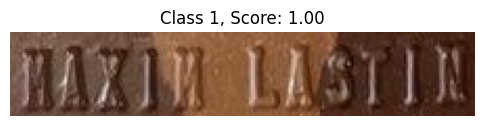

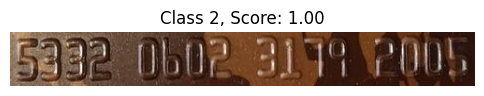

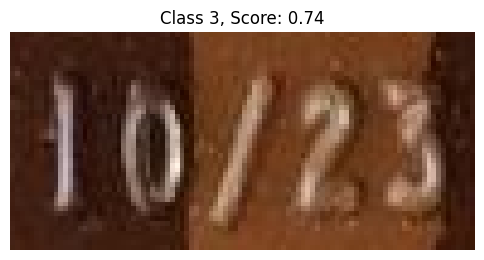

In [11]:
# Сохраняем и отображаем результаты
save_and_display_bboxes(image_path, results, confidence_threshold=0.7)

# Распознавание PaddleOCR

In [12]:
import os
from paddleocr import TextRecognition
from PIL import Image
import matplotlib.pyplot as plt

In [13]:
def visualize_enhanced_results_one_img(class_id, processed_img, full_text):
    """Визуализация обработанного изображения"""
    # Создаем фигуру только для обработанного изображения
    plt.figure(figsize=(12, 8))
    
    # Преобразование PIL.Image в numpy array
    if isinstance(processed_img, Image.Image):
        processed_img_array = np.array(processed_img)
    # Отображаем обработанное изображение
    plt.imshow(processed_img_array, cmap='gray')
    plt.title(f"Результаты распознавания (Класс {class_id})", fontsize=32)
    
    plt.axis('off')  # Скрываем оси
    plt.tight_layout()
    plt.show()

    # Вывод результатов
    print(f"Распознанный текст: '{full_text}'")

In [14]:
def recognize_images_in_directory(directory, reader):
    """
    Распознает текст на изображениях с учетом класса из имени файла
    
    Args:
        directory: путь к директории с изображениями
        languages: список языков для распознавания
        gpu: использовать ли GPU
    """
    
    # Получаем список файлов
    image_files = [f for f in os.listdir(directory) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    if not image_files:
        print(f"В директории {directory} не найдено изображений")
        return
    
    print(f"Найдено {len(image_files)} изображений для распознавания...")
    
    # Обрабатываем каждое изображение
    for img_file in image_files:
        img_path = os.path.join(directory, img_file)
        print(f"\nОбработка файла: {img_file}")
        
        try:
            # Извлекаем класс из имени файла (первый символ перед '_')
            class_id = img_file.split('_')[0]
                       
            # Загрузка и предобработка изображения
            image = Image.open(img_path).convert("RGB")

            # Увеличим маленький текст:
            # # Получаем текущие размеры
            width, height = image.size

            # Вычисляем новые размеры (увеличиваем ширину в 1.5 раза)
            new_width = int(width * 1.5)
            new_height = int(height * (new_width / width))  # Сохраняем пропорции

            # Масштабируем изображение
            resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
            
            # Распознавание с улучшенными параметрами
            results = reader.predict(input=img_path)
            
            # Результат
            recognized_text = results[0]['rec_text']
            recognized_conf = results[0]['rec_score']
            print(f"{recognized_text}, (уверенность: {recognized_conf:.3f})")
            
            # Визуализация с указанием класса
            visualize_enhanced_results_one_img(class_id, resized_image, recognized_text)


        except Exception as e:
            print(f"Ошибка при обработке файла {img_file}: {str(e)}")

Using official model (PP-OCRv4_mobile_rec), the model files will be automatically downloaded and saved in /home/lastinm/.paddlex/official_models.
/home/lastinm/PROJECTS/credit_cards_detection/.cuda118_env/lib/python3.11/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


Найдено 3 изображений для распознавания...

Обработка файла: 1_1742460932124_resized_jpg.rf.ae82439353cb014cd13031eaed480be1_crop0.jpg
HAXIM LASTIN, (уверенность: 0.896)


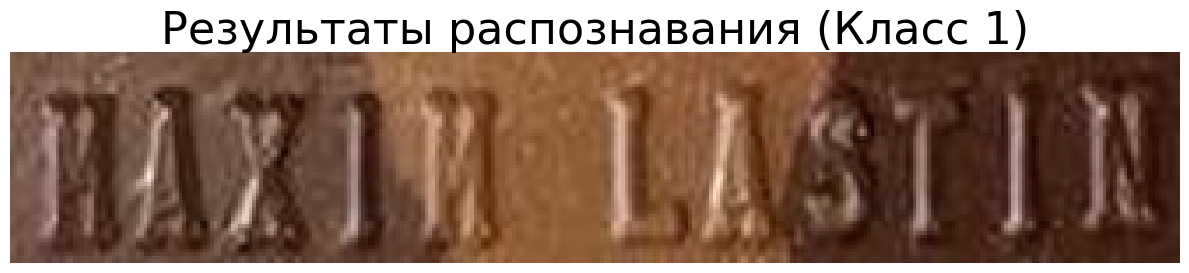

Распознанный текст: 'HAXIM LASTIN'

Обработка файла: 2_1742460932124_resized_jpg.rf.ae82439353cb014cd13031eaed480be1_crop1.jpg
5332 0602 3179 2005, (уверенность: 0.949)


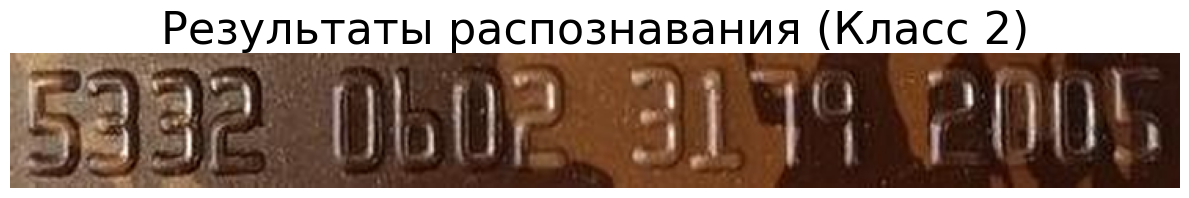

Распознанный текст: '5332 0602 3179 2005'

Обработка файла: 3_1742460932124_resized_jpg.rf.ae82439353cb014cd13031eaed480be1_crop2.jpg
10/23, (уверенность: 0.987)


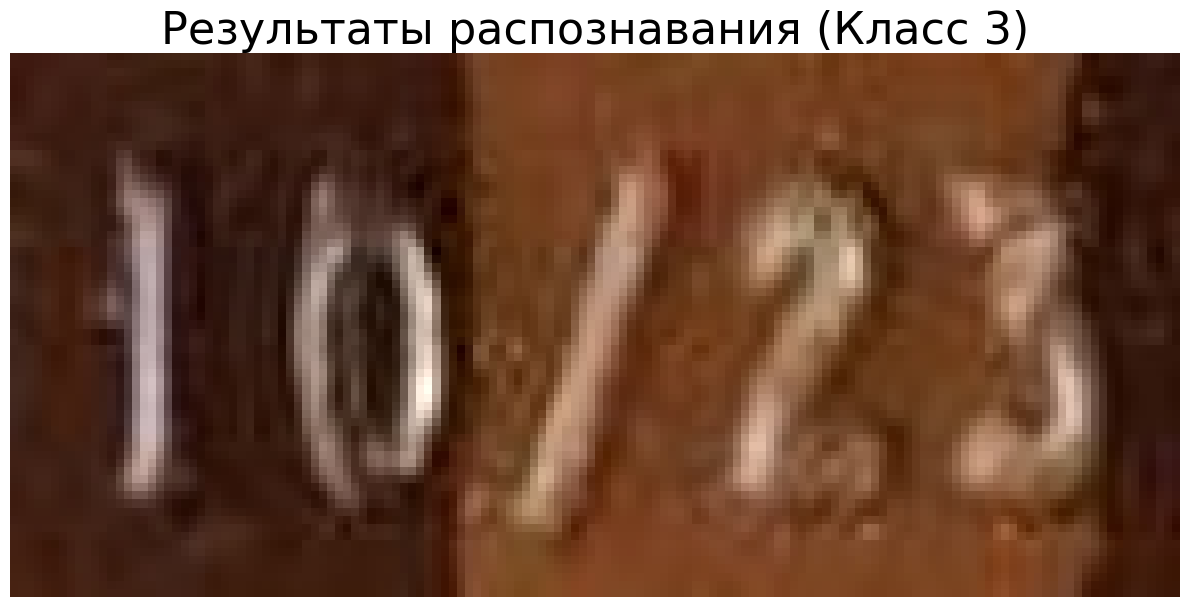

Распознанный текст: '10/23'


In [15]:
# Инициализация PaddleOCR
reader = TextRecognition()

output_dir = 'output'  # директория с изображениями
recognize_images_in_directory(output_dir, reader)